### MMDetection 설치
* 강의 영상에는 pip install mmcv-full로 mmcv를 설치(약 10분 정도의 시간이 소요)
* 실습코드는 pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu116/torch1.13/index.html 로 변경(설치에 12초 정도 걸림. 2022.09).
*  2023년 4월 6일 기준으로 mmdetection이 3.0으로 upgrade됨. 실습 코드는 mmdetection 2.x 기준으므로 mmdetection 2.x 소스코드 설치 필요.
* 2024년 9월 colab의 numpy version이 1.24로 upgrade되면서 일부 코드가 동작오류. numpy 1.23 으로 downgrade 적용
* 2025년 1월 17일 Colab의 python 버전이 3.10에서 3.11로 버전업 되면서 pytorch 2.0, torchvision 0.15로 변경. mmcv도 !pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu118/torch2.0.0/index.html 로 변경.

#### pytorch, torchvision 다운그레이드

In [ ]:
#코랩의 pytorch 버전이 2.x 로 upgrade
import torch
print(torch.__version__)

In [ ]:
!pip install torch==2.0.0 torchvision==0.15.1  --index-url https://download.pytorch.org/whl/cu118

#### mmcv-full 및 mmdetection 설치

In [ ]:
# mmcv를 위해서 mmcv-full을 먼저 설치해야 함. https://mmcv.readthedocs.io/en/latest/get_started/installation.html 설치 과정 참조.
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu118/torch2.0.0/index.html

In [ ]:
# 2023년 4월 6일 기준으로 mmdetection이 3.0으로 upgrade됨. 실습 코드는 mmdetection 2.x 기준임.
# mmdetection 2.x branch의 소스코드 기반으로 mmdetection 설치 필요.
!git clone --branch 2.x https://github.com/open-mmlab/mmdetection.git
!cd mmdetection; python setup.py install

In [ ]:
# 아래를 수행하기 전에 kernel을 restart 해야 함.
from mmdet.apis import init_detector, inference_detector
import mmcv

In [ ]:
### 반드시 numpy downgrade를 mmcv 설치 후에 실행할것.
!pip install numpy==1.23

In [ ]:
!pip install yapf==0.40.1

### PASCAL VOC형태의 BCCD Dataset를 Download 후 MS-COCO 형태로 변경
* BCCD Dataset은 백혈구(WBC), 적혈구(RBC), 혈소판(Platelets) 세가지 유형의 Object Class를 가짐.
* 다운로드 받은 Dataset은 Pascal VOC 형태이므로 이를 별도의 유틸리티를 이용하여 MS-COCO 형태로 변환


In [ ]:
!git clone https://github.com/Shenggan/BCCD_Dataset.git

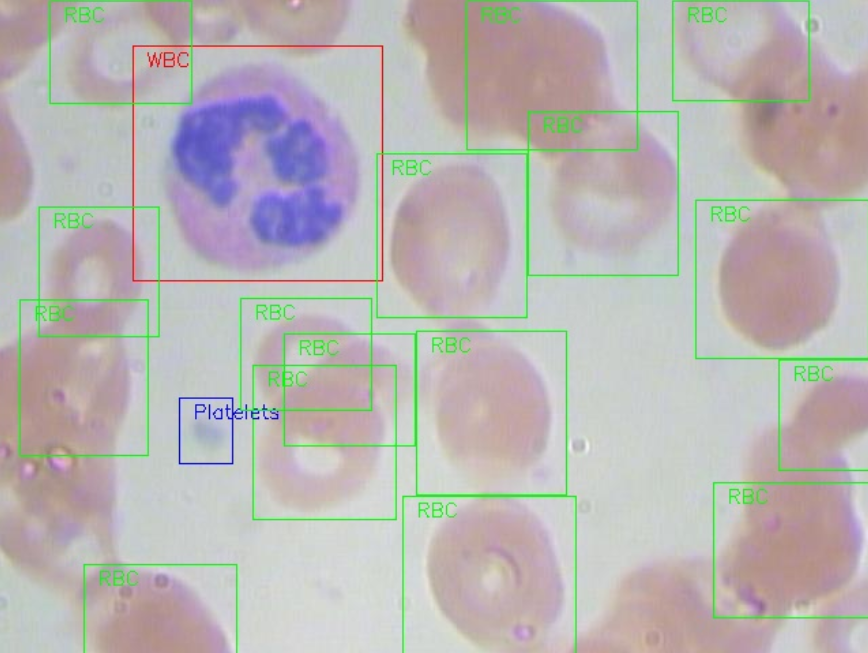

### VOC를 COCO로 변환하는 package적용하기

In [ ]:
!git clone https://github.com/yukkyo/voc2coco.git

In [ ]:
import os

# colab 버전은 아래 명령어로 ballnfish_classes.txt 를 수정합니다.
with open('/content/BCCD_Dataset/BCCD/labels.txt', "w") as f:
    f.write("WBC\n")
    f.write("RBC\n")
    f.write("Platelets\n")

!cat /content/BCCD_Dataset/BCCD/labels.txt

In [ ]:
# VOC를 COCO로 변환 수행. 학습/검증/테스트 용 json annotation을 생성.
%cd voc2coco
!python voc2coco.py --ann_dir /content/BCCD_Dataset/BCCD/Annotations \
--ann_ids /content/BCCD_Dataset/BCCD/ImageSets/Main/train.txt \
--labels /content/BCCD_Dataset/BCCD/labels.txt \
--output /content/BCCD_Dataset/BCCD/train.json \
--ext xml

!python voc2coco.py --ann_dir /content/BCCD_Dataset/BCCD/Annotations \
--ann_ids /content/BCCD_Dataset/BCCD/ImageSets/Main/val.txt \
--labels /content/BCCD_Dataset/BCCD/labels.txt \
--output /content/BCCD_Dataset/BCCD/val.json \
--ext xml

!python voc2coco.py --ann_dir /content/BCCD_Dataset/BCCD/Annotations \
--ann_ids /content/BCCD_Dataset/BCCD/ImageSets/Main/test.txt \
--labels /content/BCCD_Dataset/BCCD/labels.txt \
--output /content/BCCD_Dataset/BCCD/test.json \
--ext xml

In [ ]:
!cat /content/BCCD_Dataset/BCCD/train.json

In [ ]:
# annotation json 파일을 잘 볼수 있는 jq 유틸리티 셋업.
!sudo apt-get install jq

In [ ]:
!jq . /content/BCCD_Dataset/BCCD/train.json > output.json
!tail -100 output.json

In [ ]:
!jq . /content/BCCD_Dataset/BCCD/test.json > output.json
!cat output.json

### CocoDataset 클래스를 활용하여 BCCD Dataset을 로딩하기
* MS-COCO Dataset의 경우 별다른 Custom Code없이 Object들의 Class만 지정해 주면 됨

In [ ]:
%cd /content

In [ ]:
from mmdet.datasets.builder import DATASETS
from mmdet.datasets.coco import CocoDataset

@DATASETS.register_module(force=True)
class BCCDDataset(CocoDataset):
  CLASSES = ('WBC', 'RBC', 'Platelets')

### Config 설정하고 Checkpoint 파일 다운로드 받기

In [ ]:
config_file = '/content/mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'
checkpoint_file = '/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

In [ ]:
!pwd

In [ ]:
!cd /content/mmdetection; mkdir checkpoints
!wget -O /content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth

In [ ]:
!ls -lia /content/mmdetection/checkpoints

In [ ]:
from mmcv import Config

cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

In [ ]:
from mmdet.apis import set_random_seed

# dataset에 대한 환경 파라미터 수정.
cfg.dataset_type = 'BCCDDataset'
cfg.data_root = '/content/BCCD_Dataset/BCCD/'

# train, val, test dataset에 대한 type, data_root, ann_file, img_prefix 환경 파라미터 수정.
cfg.data.train.type = 'BCCDDataset'
cfg.data.train.data_root = '/content/BCCD_Dataset/BCCD/'
cfg.data.train.ann_file = 'train.json'
cfg.data.train.img_prefix = 'JPEGImages'

cfg.data.val.type = 'BCCDDataset'
cfg.data.val.data_root = '/content/BCCD_Dataset/BCCD/'
cfg.data.val.ann_file = 'val.json'
cfg.data.val.img_prefix = 'JPEGImages'

cfg.data.test.type = 'BCCDDataset'
cfg.data.test.data_root = '/content/BCCD_Dataset/BCCD/'
cfg.data.test.ann_file = 'test.json'
cfg.data.test.img_prefix = 'JPEGImages'

# class의 갯수 수정.
cfg.model.roi_head.bbox_head.num_classes = 3
# pretrained 모델
cfg.load_from = '/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

# 학습 weight 파일로 로그를 저장하기 위한 디렉토리 설정.
cfg.work_dir = './tutorial_exps'

# 학습율 변경 환경 파라미터 설정.
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# CocoDataset의 경우 metric을 bbox로 설정해야 함.(mAP아님. bbox로 설정하면 mAP를 iou threshold를 0.5 ~ 0.95까지 변경하면서 측정)
cfg.evaluation.metric = 'bbox'
cfg.evaluation.interval = 12
cfg.checkpoint_config.interval = 12

# 두번 config를 로드하면 lr_config의 policy가 사라지는 오류로 인하여 설정.
cfg.lr_config.policy='step'
# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
# ConfigDict' object has no attribute 'device 오류 발생시 반드시 설정 필요. https://github.com/open-mmlab/mmdetection/issues/7901
cfg.device='cuda'

In [ ]:
print(cfg.pretty_text)

### Dataset을 만들고, 모델 학습 및 Inference 적용

In [ ]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# train용 Dataset 생성.
datasets = [build_dataset(cfg.data.train)]

In [ ]:
print(datasets[0])
# datasets[0].__dict__ 로 모든 self variables의 key와 value값을 볼 수 있음.
datasets[0].__dict__.keys()

In [ ]:
datasets[0].data_infos

In [ ]:
datasets[0].pipeline

In [ ]:
model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
model.CLASSES = datasets[0].CLASSES
print(model.CLASSES)

In [ ]:
import os.path as osp
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
# epochs는 config의 runner 파라미터로 지정됨. 기본 12회
train_detector(model, datasets, cfg, distributed=False, validate=True)

In [ ]:
import cv2
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

img = cv2.imread('/content/BCCD_Dataset/BCCD/JPEGImages/BloodImage_00007.jpg')

model.cfg = cfg

result = inference_detector(model, img)
show_result_pyplot(model, img, result)

### 테스트 데이터 세트에 Inference 및 Evaluation 적용하기
* 런타임 다시 시작 수행 필요(버그?)
* tools/test.py 스크립트는 colab에서 오류 발생
* 테스트용 Dataset과 DataLoader생성하고 single_gpu_test()를 호출하여 inference 결과를 반환. batch_size를 1로 설정하지 않으면 single_gpu_test() 오류 발생.

In [ ]:
### 아래는 런타임 다시 시작 후 실행

from mmcv import Config
from mmdet.datasets.builder import DATASETS
from mmdet.datasets.coco import CocoDataset
from mmdet.apis import set_random_seed

@DATASETS.register_module(force=True)
class BCCDDataset(CocoDataset):
  CLASSES = ('WBC', 'RBC', 'Platelets')

config_file = '/content/mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'
checkpoint_file = '/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

cfg = Config.fromfile(config_file)

# dataset에 대한 환경 파라미터 수정.
cfg.dataset_type = 'BCCDDataset'
cfg.data_root = '/content/BCCD_Dataset/BCCD/'

# train, val, test dataset에 대한 type, data_root, ann_file, img_prefix 환경 파라미터 수정.
cfg.data.train.type = 'BCCDDataset'
cfg.data.train.data_root = '/content/BCCD_Dataset/BCCD/'
cfg.data.train.ann_file = 'train.json'
cfg.data.train.img_prefix = 'JPEGImages'

cfg.data.val.type = 'BCCDDataset'
cfg.data.val.data_root = '/content/BCCD_Dataset/BCCD/'
cfg.data.val.ann_file = 'val.json'
cfg.data.val.img_prefix = 'JPEGImages'

cfg.data.test.type = 'BCCDDataset'
cfg.data.test.data_root = '/content/BCCD_Dataset/BCCD/'
cfg.data.test.ann_file = 'test.json'
cfg.data.test.img_prefix = 'JPEGImages'

# class의 갯수 수정.
cfg.model.roi_head.bbox_head.num_classes = 3
# pretrained 모델
cfg.load_from = '/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

# 학습 weight 파일로 로그를 저장하기 위한 디렉토리 설정.
cfg.work_dir = './tutorial_exps'

# 학습율 변경 환경 파라미터 설정.
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# CocoDataset의 경우 metric을 bbox로 설정해야 함.(mAP아님. bbox로 설정하면 mAP를 iou threshold를 0.5 ~ 0.95까지 변경하면서 측정)
cfg.evaluation.metric = 'bbox'
cfg.evaluation.interval = 12
cfg.checkpoint_config.interval = 12

# bug(?)로 인해 test용 dataset evaluation 시 1로 설정. data loader에서 GPU갯수별 Batch size 임.
cfg.data.samples_per_gpu = 1

# 두번 config를 로드하면 lr_config의 policy가 사라지는 오류로 인하여 설정.
cfg.lr_config.policy='step'
# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
print(cfg.pretty_text)

In [ ]:
cfg.dump('/content/tutorial_exps/bccd_faster_rcnn_conf.py')

In [ ]:
!mkdir -p /content/show_test_output

In [ ]:
# tools/test.py 는 colab에서 제대로 동작하지 않음.
%cd /content/mmdetection
!python tools/test.py /content/tutorial_exps/bccd_faster_rcnn_conf.py /content/tutorial_exps/epoch_12.pth \
--eval 'bbox' \
--show-dir /content/show_test_output

### 테스트용 dataset와 dataloader를 별도로 설정하고 trained된 checkpoint 모델을 로딩하여 test 수행.

In [ ]:
from mmdet.datasets import (build_dataloader, build_dataset,
                            replace_ImageToTensor)

# test용 Dataset과 DataLoader 생성.
# build_dataset()호출 시 list로 감싸지 않는 것이 train용 dataset 생성시와 차이.
dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(
        dataset,
        # 반드시 아래 samples_per_gpu 인자값은 1로 설정
        samples_per_gpu=cfg.data.samples_per_gpu,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)

# 반드시 아래 코드에서 'img' 키값이 tensor로 출력되어야 함.
next(iter(data_loader))

In [ ]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

checkpoint_file = '/content/tutorial_exps/epoch_12.pth'

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용.
model_ckpt = init_detector(cfg, checkpoint_file, device='cuda:0')

In [ ]:
from mmdet.apis import multi_gpu_test, single_gpu_test
from mmcv.parallel import MMDataParallel, MMDistributedDataParallel
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

model_ckpt = MMDataParallel(model_ckpt, device_ids=[0])
# single_gpu_test() 를 호출하여 test데이터 세트의 interence 수행. 반드시 batch size는 1이 되어야 함.
# 위에서 만든 /content/show_test_output 디렉토리에 interence 결과가 시각화된 이미지가 저장됨.
outputs = single_gpu_test(model_ckpt, data_loader, True, '/content/show_test_output', 0.3)

### batch 크기를 1보다 키우고 테스트 수행 하려면
* 만일 batch size를 1보다 크게 해서 설정하려면 cfg.data.samples_per_gpu 값을 1보다 크게 설정하고 single_gpu_test() 함수의 bug(?) 코드를 수정 필요.
* 다시 런타임 다시 시작을 실행 후 config 부터 재 설정후 아래 코드 수행 필요. 여기서는 수행하지 않는 걸로 스킵

In [ ]:
import os.path as osp
import pickle
import shutil
import tempfile
import time

import mmcv
import torch
import torch.distributed as dist
from mmcv.image import tensor2imgs
from mmcv.runner import get_dist_info
'''
def single_gpu_test_batch(model,
                    data_loader,
                    show=False,
                    out_dir=None,
                    show_score_thr=0.3):
    model.eval()
    results = []
    dataset = data_loader.dataset
    prog_bar = mmcv.ProgressBar(len(dataset))
    for i, data in enumerate(data_loader):
        with torch.no_grad():
            result = model(return_loss=False, rescale=True, **data)

        batch_size = len(result)
        if show or out_dir:
            if batch_size == 1 and isinstance(data['img'][0], torch.Tensor):
                img_tensor = data['img'][0]
            else:
                # 아래 코드를 주석 처리 필요. batch_size가 1보다 클때는 data['img'][0].data[0]가 아니라 data['img'][0].data 가 되어야 함.
                #img_tensor = data['img'][0].data[0]
                # 아래는 버그(?) 수정 코드
                img_tensor = data['img'][0].data
                print('img_tensor shape2:', img_tensor.shape)
            img_metas = data['img_metas'][0].data[0]
            imgs = tensor2imgs(img_tensor, **img_metas[0]['img_norm_cfg'])
            assert len(imgs) == len(img_metas)

            for i, (img, img_meta) in enumerate(zip(imgs, img_metas)):
                h, w, _ = img_meta['img_shape']
                img_show = img[:h, :w, :]

                ori_h, ori_w = img_meta['ori_shape'][:-1]
                img_show = mmcv.imresize(img_show, (ori_w, ori_h))

                if out_dir:
                    out_file = osp.join(out_dir, img_meta['ori_filename'])
                else:
                    out_file = None

                model.module.show_result(
                    img_show,
                    result[i],
                    show=show,
                    out_file=out_file,
                    score_thr=show_score_thr)

        # encode mask results
        if isinstance(result[0], tuple):
            result = [(bbox_results, encode_mask_results(mask_results))
                      for bbox_results, mask_results in result]
        results.extend(result)

        for _ in range(batch_size):
            prog_bar.update()
    return results

from mmdet.apis import multi_gpu_test, single_gpu_test
from mmcv.parallel import MMDataParallel, MMDistributedDataParallel
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

model_ckpt = MMDataParallel(model_ckpt, device_ids=[0])
# single_gpu_test() 를 호출하여 test데이터 세트의 interence 수행. 반드시 batch size는 1이 되어야 함.
outputs = single_gpu_test_batch(model_ckpt, data_loader, True, '/content/tutorial_exps', 0.3)
'''

### 반환된 test용 데이터세트의 inference 적용 결과 확인 및 성능 evaluation 수행.

In [ ]:
print('결과 outputs type:', type(outputs))
print('evalution 된 파일의 갯수:', len(outputs))
print('첫번째 evalutation 결과의 type:', type(outputs[0]))
print('첫번째 evaluation 결과의 CLASS 갯수:', len(outputs[0]))
print('첫번째 evaluation 결과의 CLASS ID 0의 type과 shape', type(outputs[0][0]), outputs[0][0].shape)

In [ ]:
print(outputs)

In [ ]:
metric = dataset.evaluate(outputs, metric='bbox')
print(metric)